# NiN之Pytorch实现
## 全连接层的问题
- 全连接层的参数量过大。最重要的问题是会带来过拟合。
- 卷积层的参数=ci*co\*k^2
- 卷积层后的第一个全连接层的参数:  
    - LeNet 16x5x5x120=48K
    - AlexNet 256x5x5x4096=26M
    - VGG 512x7x7x4096=102M  
- VGG占用的内存很大，参数量巨大，最大的参数量就是在卷积层后的第一个全连接层。
- 带来了一系列问题：  
（1）占用大量的内存（2）占用大量的计算带宽
- NiN的思想：既然全连接层效果不好，就完全不要全连接层。
## NiN介绍
### NiN块
- 一个卷积层后跟两个全连接层
    - 步幅1，无填充，输出形状跟卷积层输入一样
    - 不改变通道数
    - 起到全连接层的作用
- ![](https://cdn.jsdelivr.net/gh/tangger2000/PicHost/img202202151003546.png)
- ![](https://cdn.jsdelivr.net/gh/tangger2000/PicHost/img202202151008629.png)
- 我们可以认为上图的NiN块就是一个非常简单的神经网络，唯一不同的是，我们这里的NiN是对每一个像素进行“全连接”。
### NiN架构
- 无全连接层
- 交替使用NiN块和步幅为2的最大池化层
    - 逐步减小高宽和增大通道数
- 最后使用全局平均池化层得到输出
    - 其输入通道数是类别数
- ![](https://cdn.jsdelivr.net/gh/tangger2000/PicHost/img202202151012748.png)
### NiN架构总结
- NiN块使用卷积层加两个1x1卷积层
    - 后者对每个像素增加了非线性性
- NiN使用全局平均池化层来替代VGG和AlexNet中的全连接层
    - 不容易过拟合，更少的参数个数

## NiN代码实现
NiN块

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

def nin_block(in_channels, out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding), nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU()
    )

NiN模型

In [3]:
net = nn.Sequential(
    nin_block(1, 96, kernel_size=11, strides=4, padding=0),
    nn.MaxPool2d(3, stride=2),
    nin_block(96, 256, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(3, stride=2),
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3, stride=2), nn.Dropout(0.5),
    nin_block(384, 10, kernel_size=3, strides=1, padding=1),
    nn.AdaptiveAvgPool2d((1,1)),
    nn.Flatten()
)

查看每个块的输出形状

In [4]:
X = torch.randn(size=(1,1,224,224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'Output shape:\t', X.shape)

Sequential Output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d Output shape:	 torch.Size([1, 96, 26, 26])
Sequential Output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d Output shape:	 torch.Size([1, 256, 12, 12])
Sequential Output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d Output shape:	 torch.Size([1, 384, 5, 5])
Dropout Output shape:	 torch.Size([1, 384, 5, 5])
Sequential Output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d Output shape:	 torch.Size([1, 10, 1, 1])
Flatten Output shape:	 torch.Size([1, 10])


验证模型和训练模型的函数定义

In [5]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    if isinstance(net, torch.nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device
    metric = d2l.Accumulator(2)
    for X,y in data_iter:
        if isinstance(X, list):
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y=y.to(device)
        metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0]/metric[1]

def train(net, train_iter, test_iter, num_epochs, lr ,device):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on',device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])

    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X,y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X,y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            metric.add(l*X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0]/metric[2]
            train_acc = metric[1]/metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

模型训练

loss 0.200, train acc 0.927, test acc 0.911
313.2 examples/sec on cuda:0


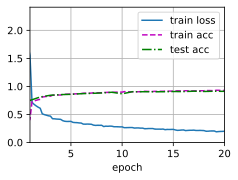

In [6]:
lr, num_epochs, batch_size = 0.05, 20 ,32
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=(224,224))
train(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())